In [3]:
import json
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
from numpy.polynomial.polynomial import Polynomial
from sklearn.linear_model import LinearRegression
import math

In [3]:
#Load and handle power data

# Load JSON
with open('generation.json', 'r') as file:
    data = json.load(file)

# Extract timestamps and values
timestamps_power = [datetime.strptime(ts, '%Y-%m-%dT%H:%M:%S') for ts in data.keys()]
values_power = list(data.values())


#Load and handle temperature data

# Load XML
tree = ET.parse('temperatures.xml')
root = tree.getroot()

# Initialize dictionary to hold data
forecast_data = {}

# Extract data for each forecast
for forecast in root.findall('forecast'):
    forecast_name = forecast.get('name')
    timestamps_spot_time = []
    temps_celsius = []

    for point in forecast.findall('point'):
        spot_time = point.find('spot_time').text
        temp_celsius = float(point.find('temp_celsius').text)
        
        # Convert to datetime
        timestamp = datetime.strptime(spot_time, '%Y-%m-%dT%H:%M:%S')
        
        timestamps_spot_time.append(timestamp)
        temps_celsius.append(temp_celsius)
    
    forecast_data[forecast_name] = (timestamps_spot_time, temps_celsius)

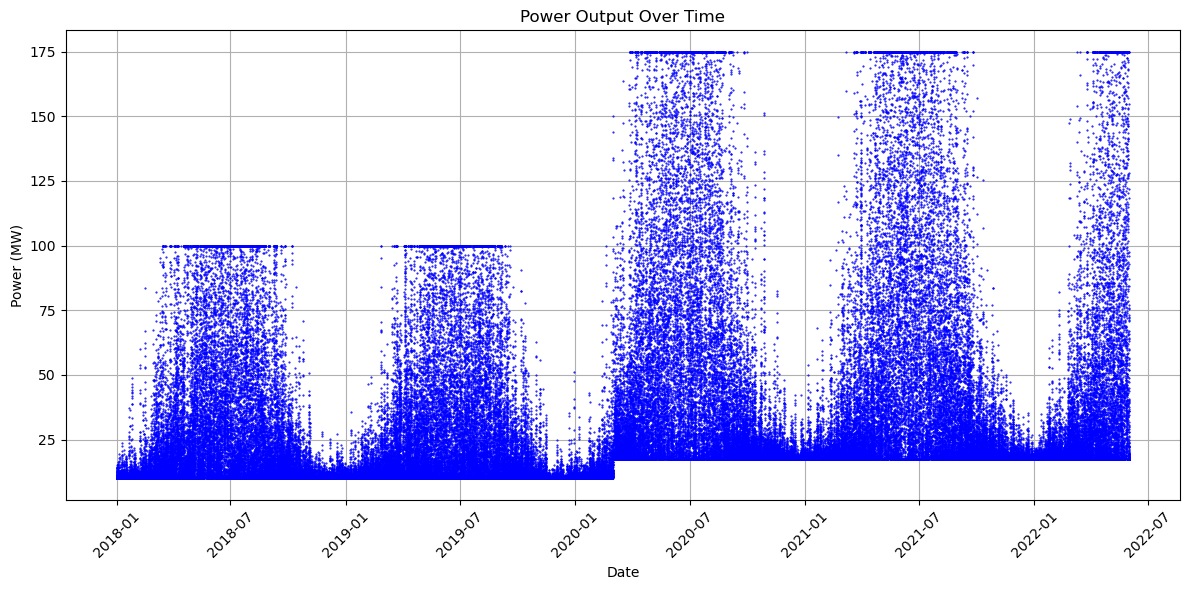

In [176]:
# Plot the power data
plt.figure(figsize=(12, 6))
plt.plot(timestamps_power, values_power, marker='o', linestyle='', color='b', markersize=0.5)
plt.xlabel('Date')
plt.ylabel('Power (MW)')
plt.xticks(rotation=45)
plt.title('Power Output Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
'''
Initial obervations:

Power output seems to be seasonal with power peaking in the middle of the year and reaching its lowest at the beginning/end of the year.
The power is capped above and below.
The distribution of data changes just after the start of 2020, it is hard to tell from this graph if this is just the caps changing or the underlying distribition.
We will investigate this by checking the number of values above or equal to the initial cap each year. If the underlying distribution is the same after the change this should remain similar.
We will also calculate the caps and the time that the data changes.
'''

In [5]:
#We calculate the caps and the time that the data changes

# Examine 2018 to calculate intial caps
start_date = datetime(2018, 1, 1)
end_date = datetime(2018, 12, 31, 23, 59, 59)

# Filter data for the specified year
filtered_timestamps = [ts for ts in timestamps_power if start_date <= ts <= end_date]
filtered_values = [data[ts.strftime('%Y-%m-%dT%H:%M:%S')] for ts in filtered_timestamps]

# Calculate and print caps
print("The initial lower cap is: " + str(min(filtered_values)))
print("The initial upper cap is: " + str(max(filtered_values)))

# Examine 2021 to calculate later caps
start_date = datetime(2021, 1, 1)
end_date = datetime(2021, 12, 31, 23, 59, 59)

# Filter data for the specified year
filtered_timestamps = [ts for ts in timestamps_power if start_date <= ts <= end_date]
filtered_values = [data[ts.strftime('%Y-%m-%dT%H:%M:%S')] for ts in filtered_timestamps]

# Calculate and print caps
print("The new lower cap is: " + str(min(filtered_values)))
print("The new upper cap is: " + str(max(filtered_values)))


# Get timestamps corresponding to values equal to the initial lower cap
target_timestamps = [ts for ts in timestamps_power if data[ts.strftime('%Y-%m-%dT%H:%M:%S')] == 10] # 10 was added after calculating the initial lower cap
    
# Return the last time the initial lower cap is reached
if target_timestamps:
    print("The date the data changes is: " + str(max(target_timestamps).strftime('%Y-%m-%dT%H:%M:%S')))

#This may be very slighly inaccurate as we may have values after this date capped below at 10 that don't reach the cap. Given the scale of the data this shouldn't be a problem.

The initial lower cap is: 10.0
The initial upper cap is: 100
The new lower cap is: 17.5
The new upper cap is: 175
The date the data changes is: 2020-02-28T16:02:00


In [175]:
# Define the years for filtering
years = [2018, 2019, 2020, 2021]

# Initialize a dictionary to store the count for each year
counts_above_100 = {}

# Loop over each year
for year in years:
    # Define the start and end dates for the year
    start_date = datetime(year, 1, 1)
    end_date = datetime(year, 12, 31, 23, 59, 59)

    # Filter timestamps for the current year
    filtered_timestamps = [ts for ts in timestamps_power if start_date <= ts <= end_date]

    # Extract values corresponding to the filtered timestamps
    filtered_values = [data[ts.strftime('%Y-%m-%dT%H:%M:%S')] for ts in filtered_timestamps]

    # Count the number of data points where the value is above 100
    count_above_100 = sum(1 for value in filtered_values if value >= 100)

    # Store the count in the dictionary
    counts_above_100[year] = count_above_100

# Print the results
for year, count in counts_above_100.items():
    print(f"Number of data points greater than or equal to 100 in {year}: {count}")

'''
Maybe get rid of dictionary and just print in the for loop
'''

Number of data points greater than or equal to 100 in 2018: 1571
Number of data points greater than or equal to 100 in 2019: 1508
Number of data points greater than or equal to 100 in 2020: 3850
Number of data points greater than or equal to 100 in 2021: 3863


In [ ]:
'''
This is convincing proof that it is not just the caps that have changed but the underlying distribution of the data has changed. Lets compare a single year of the data before and a single year of the data after the change to see if there's any other information we can observe.
'''

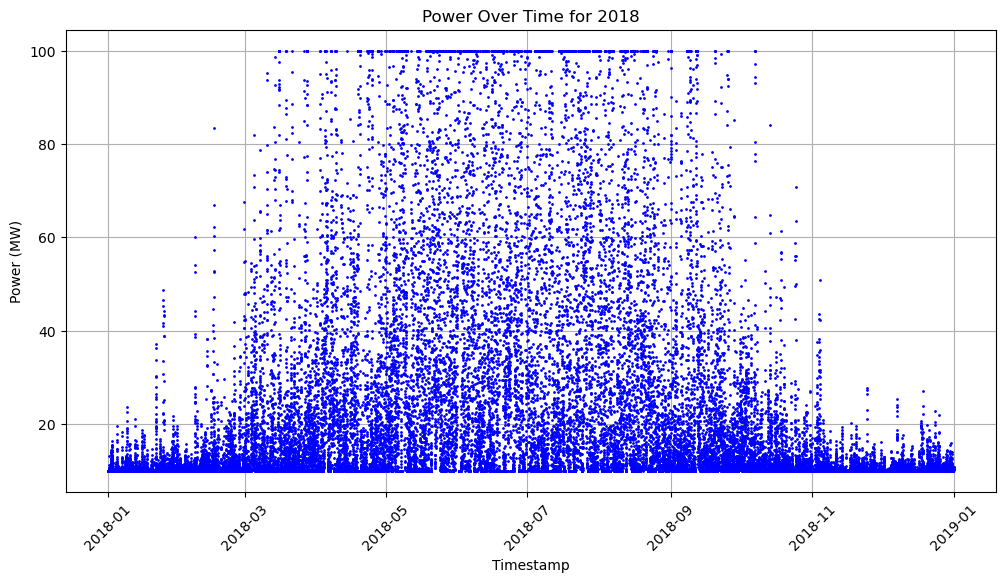

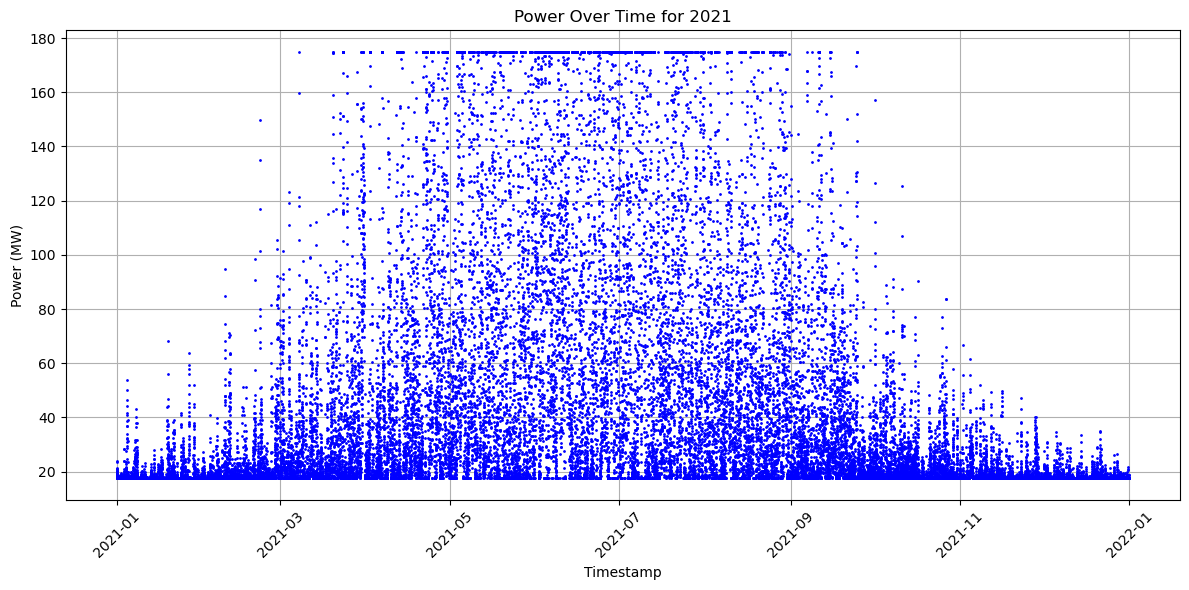

In [7]:
# Define the year for filtering
start_date = datetime(2018, 1, 1)
end_date = datetime(2018, 12, 31, 23, 59, 59)

# Filter data for the specified year
filtered_timestamps = [ts for ts in timestamps_power if start_date <= ts <= end_date]
filtered_values = [data[ts.strftime('%Y-%m-%dT%H:%M:%S')] for ts in filtered_timestamps]

# Plot the filtered data
plt.figure(figsize=(12, 6))
plt.plot(filtered_timestamps, filtered_values, marker='o', linestyle='', color='b', markersize=1)
plt.xlabel('Timestamp')
plt.ylabel('Power (MW)')
plt.title('Power Over Time for 2018')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)

# Define the year for filtering
start_date = datetime(2021, 1, 1)
end_date = datetime(2021, 12, 31, 23, 59, 59)

# Filter data for the specified year
filtered_timestamps = [ts for ts in timestamps_power if start_date <= ts <= end_date]
filtered_values = [data[ts.strftime('%Y-%m-%dT%H:%M:%S')] for ts in filtered_timestamps]

# Plot the filtered data
plt.figure(figsize=(12, 6))
plt.plot(filtered_timestamps, filtered_values, marker='o', linestyle='', color='b', markersize=1)
plt.xlabel('Timestamp')
plt.ylabel('Power (MW)')
plt.title('Power Over Time for 2021')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
'''
There doesn't seem to be anything to observe from these 2 graphs so we will move on and look at the heat data.
'''

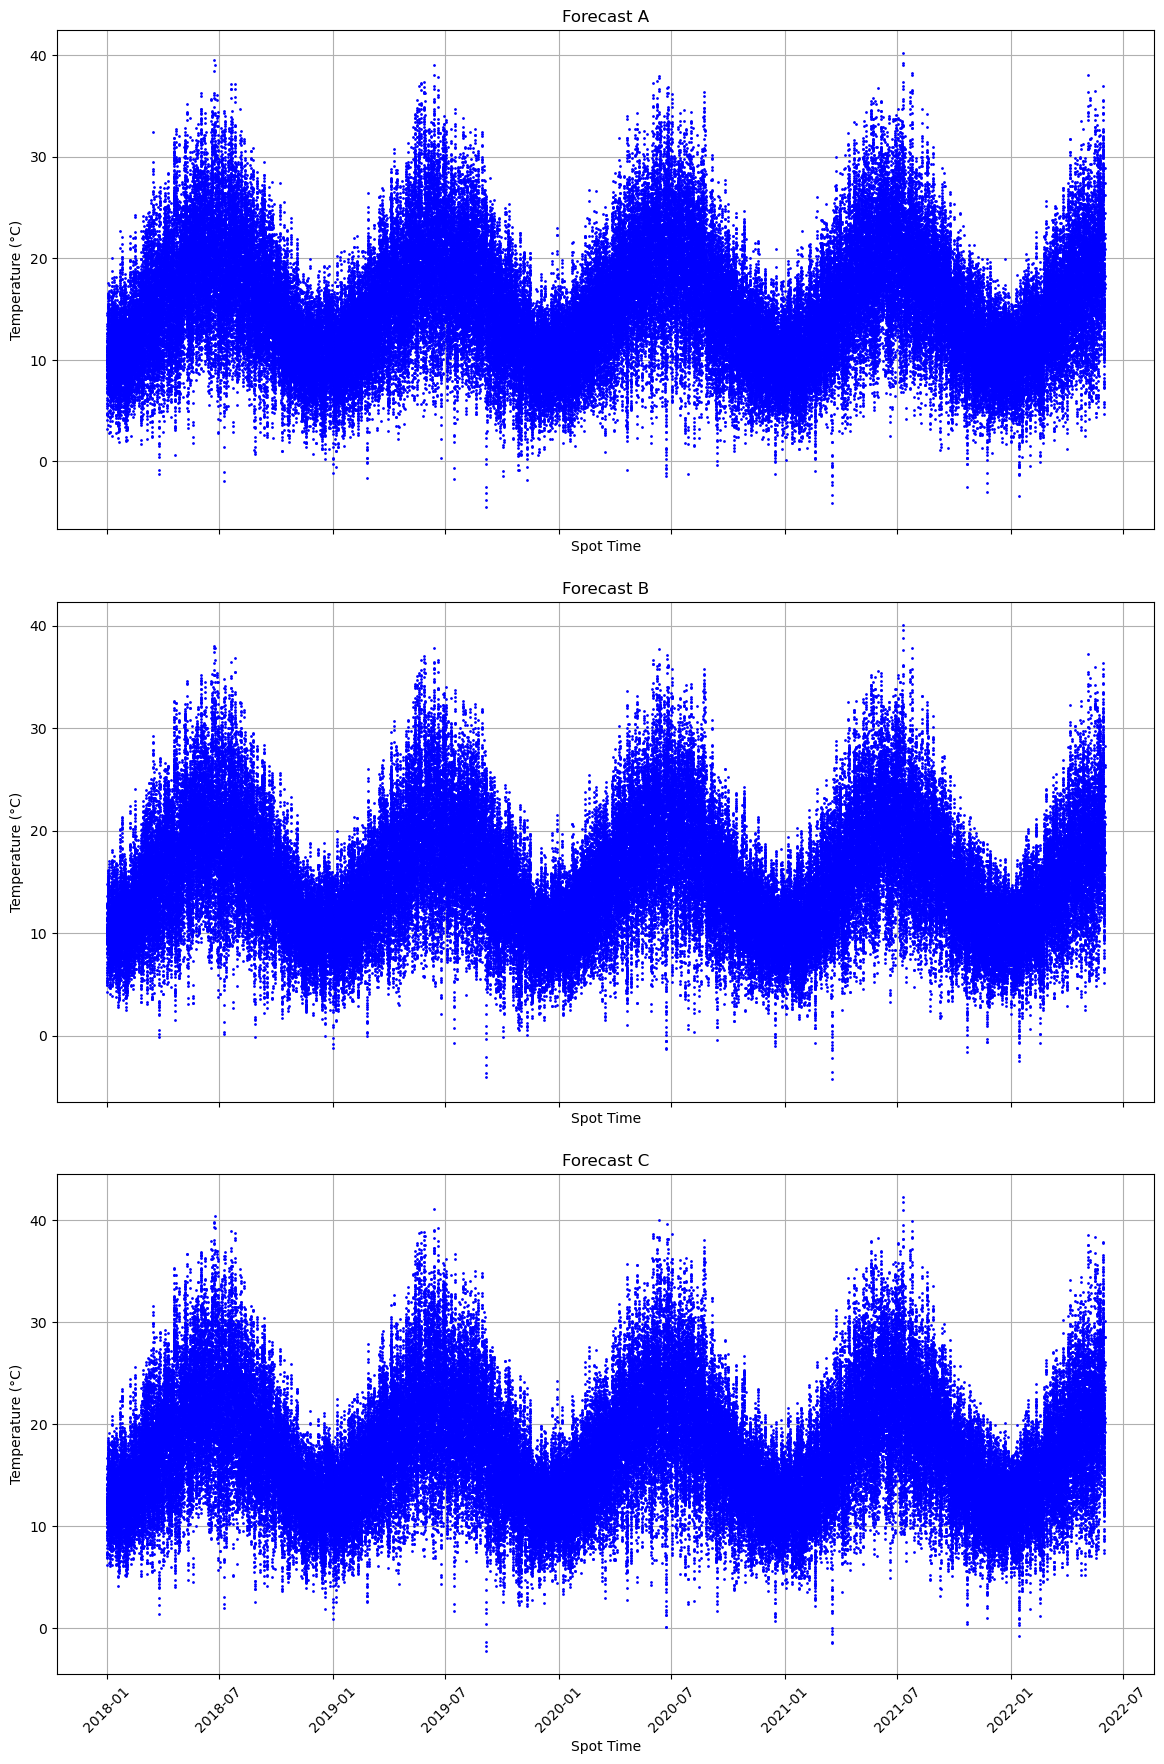

In [8]:
# Create subplots for the 3 forecasts
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
'''
is this done weirldy
'''
# Plot data for each forecast in separate subplots
for i, (forecast_name, (timestamps, values)) in enumerate(forecast_data.items()):
    ax = axes[i]
    ax.plot(timestamps, values, marker='o', linestyle='', color='b', markersize=1)
    ax.set_ylabel('Temperature (°C)')
    ax.set_title(f'{forecast_name}')
    ax.grid(True)

# Set x-axis labels and format
axes[-1].set_xlabel('Spot Time')
plt.setp(axes, xlabel='Spot Time', ylabel='Temperature (°C)')
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

# Show the plot
plt.tight_layout(pad=2.0)
plt.show()

In [ ]:
'''
Initial observations:
All three temperature graphs seem very similar.
Temperature seems to be seasonal which is unsurprising, with temperature peaking in the middle of the year and reaching its lowest at the start/end of the year. This aligns with the peaks in the power data ignoring the caps.
We also note that the temperature data does't change midway through as it does in the power data.
It seems that the power plant correlates with the temperature (ignoring caps) but that the correlation changes slighlty just after 2020 as the plant has possibly been upgraded.
We will plot the temperature data against the power data, it is likely we will have to seperate the data into 2 data sets before and after the data shifts.
We will only plot data points with a time value in both data sets meaning that we are potentially discarding data. This could be a problem but we will find out.
'''

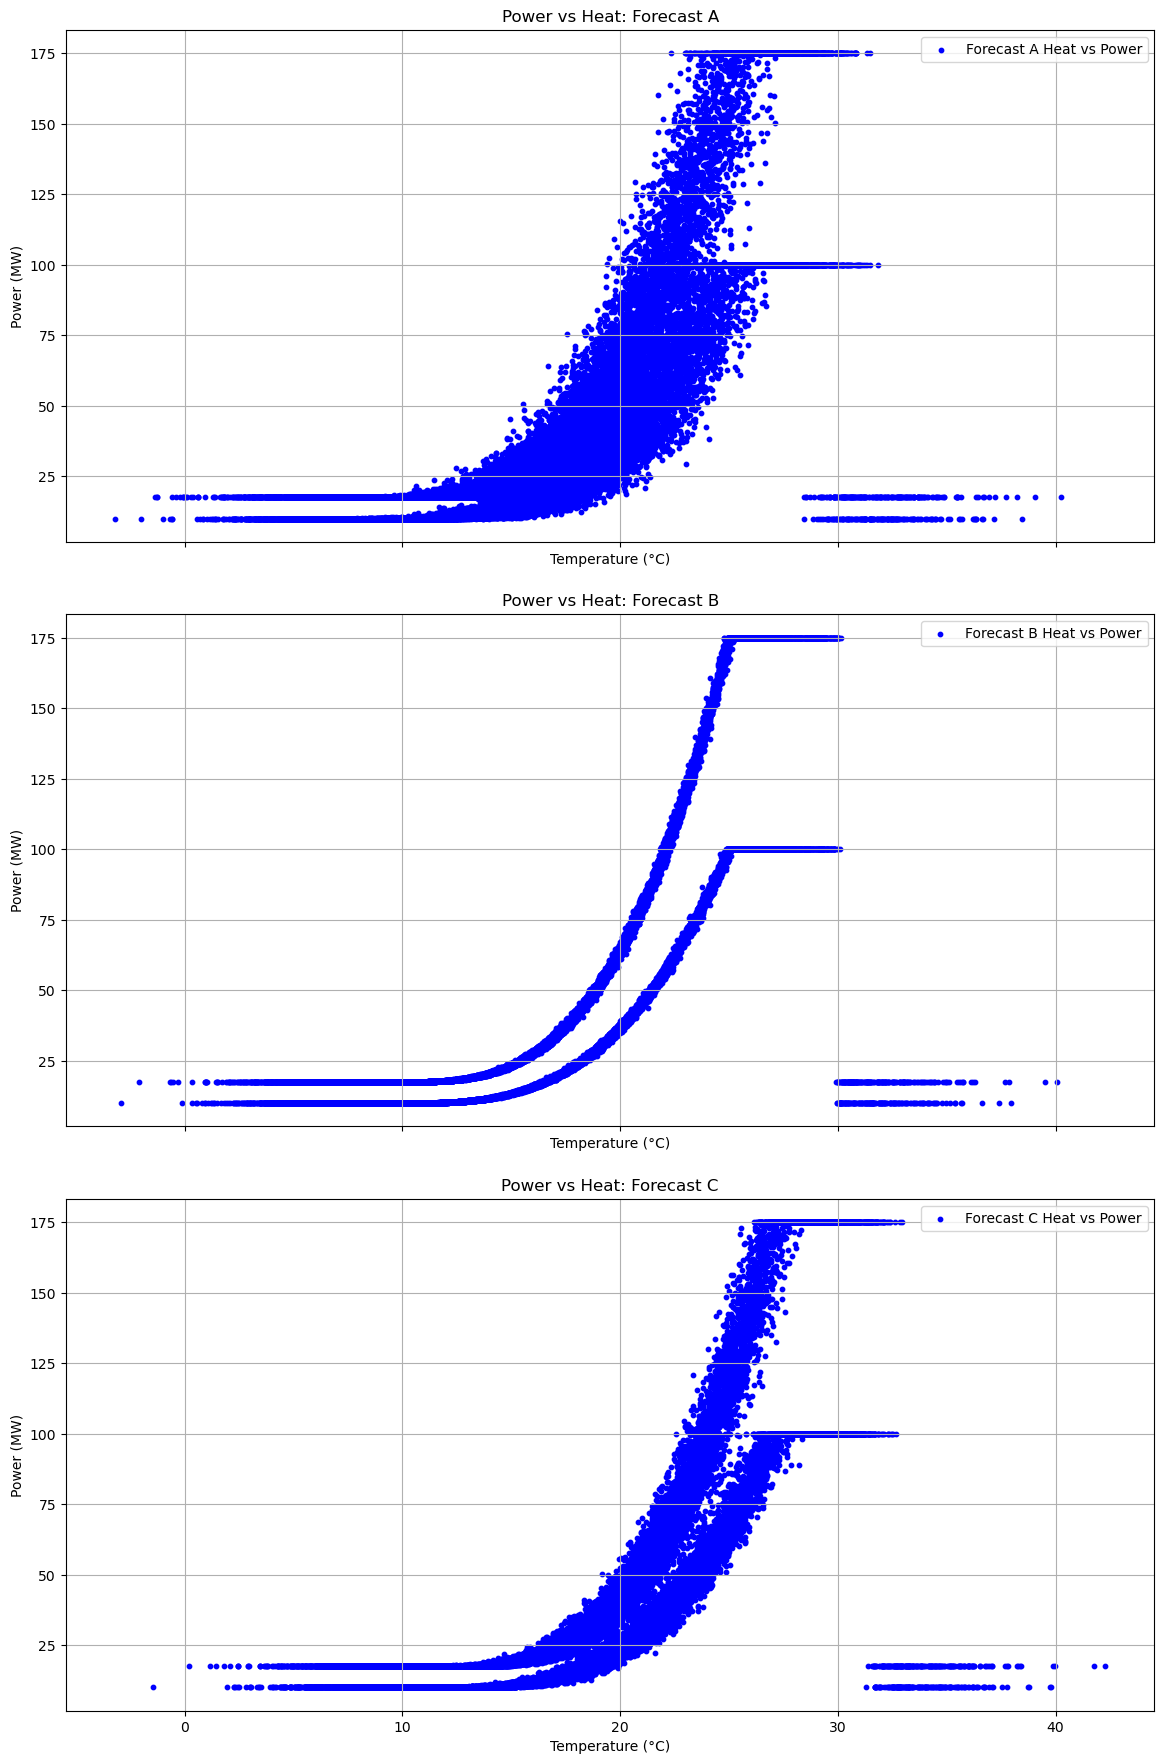

In [9]:
# Initialize dictionaries to hold matching data
matching_data = {}

# Process and save matching data for each forecast
for forecast_name, (timestamps_heat, temps_heat) in forecast_data.items():
    '''
    don't fully undertsand this need to see if it can be simplified
    '''
    # Ensure matching timestamps between power and heat
    common_timestamps = set(timestamps_power) & set(timestamps_heat)
    
    if common_timestamps:
        # Get power values for the common timestamps
        power_values = [data[ts.strftime('%Y-%m-%dT%H:%M:%S')] for ts in common_timestamps]
        
        # Get heat values corresponding to the common timestamps
        heat_values = [temps_heat[timestamps_heat.index(ts)] for ts in common_timestamps]
        
        # Save the matching data
        matching_data[forecast_name] = (heat_values, power_values)

# Plot data for each forecast
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

for i, (forecast_name, (heat_values, power_values)) in enumerate(matching_data.items()):
    ax = axes[i]
    ax.scatter(heat_values, power_values, color='b', marker='o', s=10, label=f'{forecast_name} Heat vs Power')
    ax.set_ylabel('Power (MW)')
    ax.set_xlabel('Temperature (°C)')
    ax.set_title(f'Power vs Heat: {forecast_name}')
    ax.grid(True)
    ax.legend()

# Show the plots
plt.tight_layout(pad=2.0)
plt.show()

In [ ]:
'''
Even potentially discarding data we seem to see a clear trend in all three graphs. I think it's safe to assume that the discarded data is random and is not causing the trend we are seeing. As a result we will continue with this potentially smaller set of data as it is most likely
representative of the entire data set. In each graph we can see what appears to be 2 different sets of data most likely data before and after the shift. We can also see the capped values. Forecast B clearly has the highest correlation between the 2 sets of data.

We will now plot only the data after the shift (obviously if the power plant has changed, the newest data is the only relavent data for making future predictions).
'''

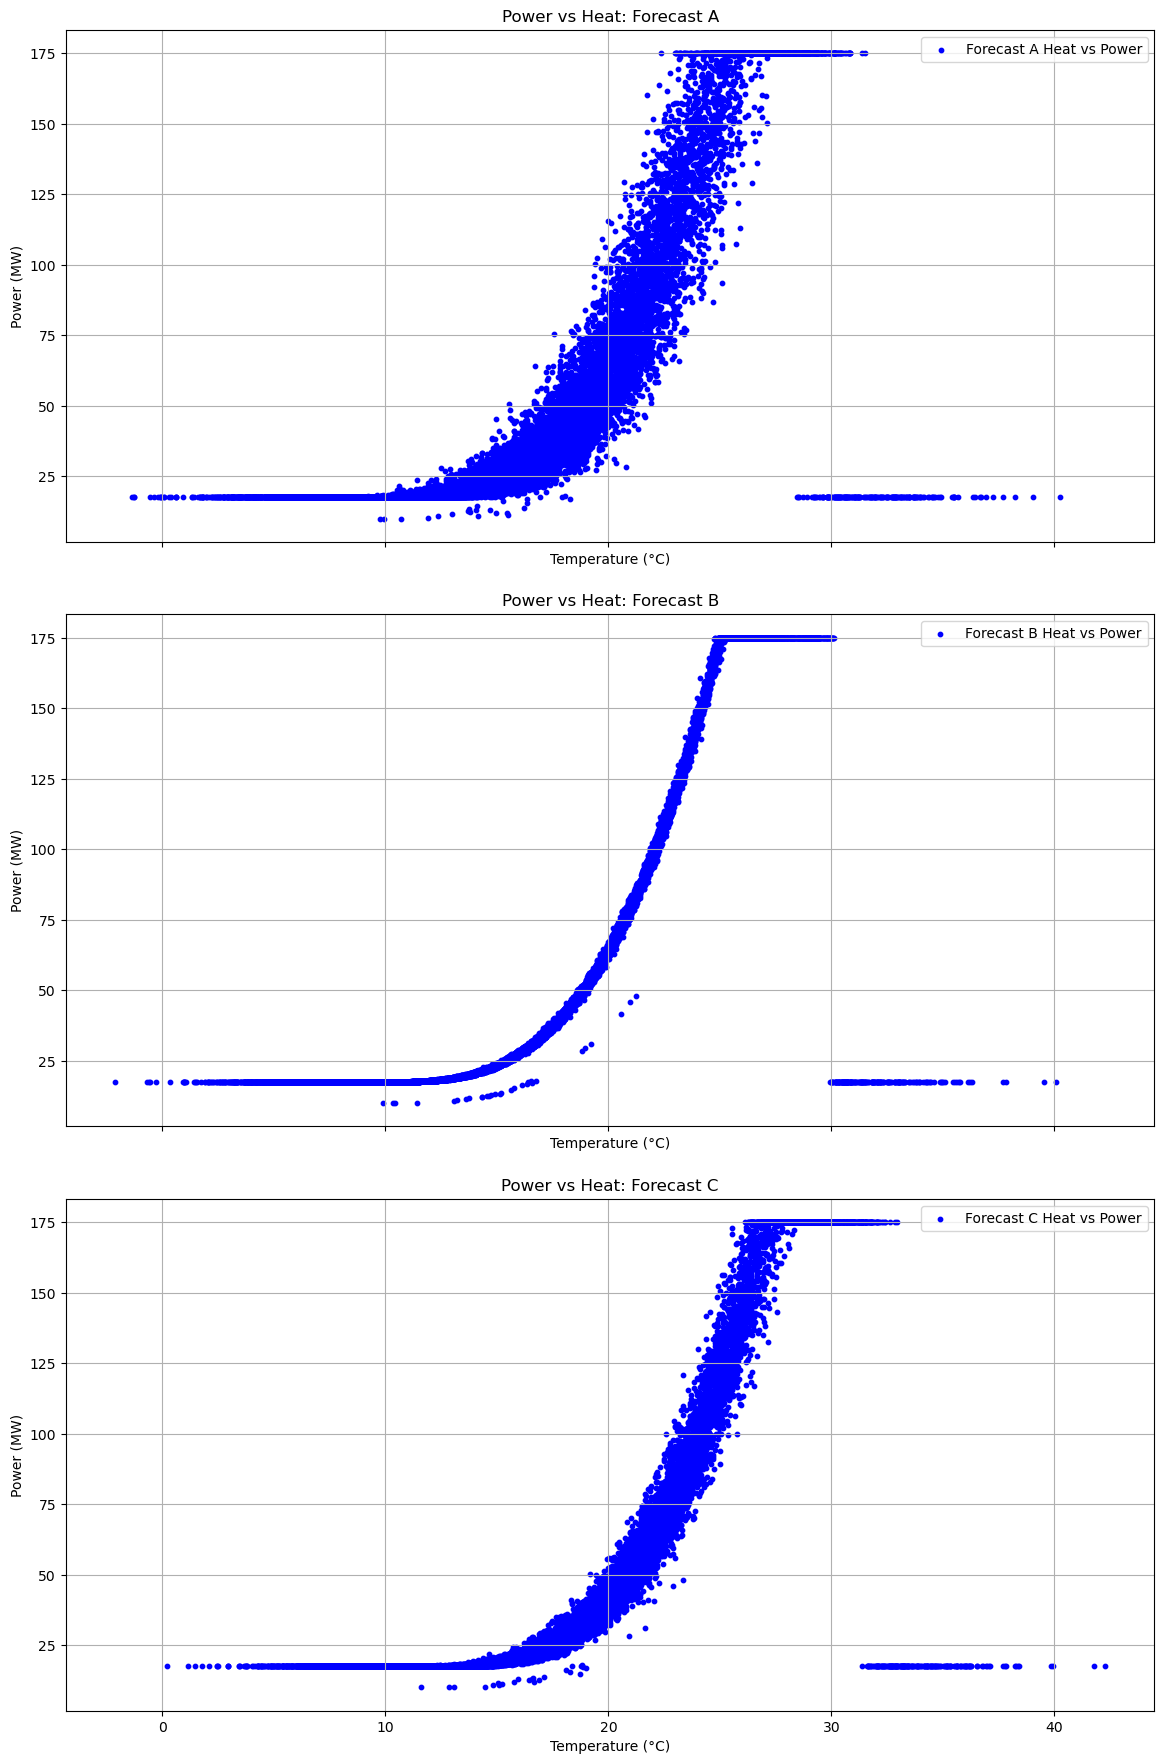

In [10]:
# Define filter start date
filter_start_date = datetime(2020, 2, 28, 16, 2, 0)

# Initialize dictionaries to hold matching data
matching_data = {}

# Process and save matching data for each forecast
for forecast_name, (timestamps_heat, temps_heat) in forecast_data.items():
    '''
    weird if again
    '''
    # Ensure matching timestamps between power and heat
    common_timestamps = set(timestamps_power) & set(timestamps_heat)
    
    # Filter common timestamps to only include those after the filter_start_date
    filtered_common_timestamps = [ts for ts in common_timestamps if ts > filter_start_date]
    
    if filtered_common_timestamps:
        # Get power values for the filtered timestamps
        power_values = [data[ts.strftime('%Y-%m-%dT%H:%M:%S')] for ts in filtered_common_timestamps]
        
        # Get heat values corresponding to the filtered timestamps
        heat_values = [temps_heat[timestamps_heat.index(ts)] for ts in filtered_common_timestamps]

        # Save the matching data
        matching_data[forecast_name] = (heat_values, power_values)

# Plotting
'''
potentially weird plotting again
'''
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# Plot data for each forecast
for i, (forecast_name, (heat_values, power_values)) in enumerate(matching_data.items()):
    ax = axes[i]
    ax.scatter(heat_values, power_values, color='b', marker='o', s=10, label=f'{forecast_name} Heat vs Power')
    ax.set_ylabel('Power (MW)')
    ax.set_xlabel('Temperature (°C)')
    ax.set_title(f'Power vs Heat: {forecast_name}')
    ax.grid(True)
    ax.legend()

# Show the plots
plt.tight_layout(pad=2.0)
plt.show()

In [ ]:
'''
The graphs look much clearer now. We will discard the rest of the data (before the shift) as it clearly isn't relevant for making future predictions as the correlation between the 2 variables has changed. Furthermore we see much higher correlation between power and heat in forecast B so we will discard the other
forecasts. It is possible that they may have information that could help us predict the power of the plant but for simplicity we will just use forecast B. As well as this in order to find a trend we will ignore capped values for now and remove outliers by inspection.
(These outliers may have arisen due to a slightly innacurate shift date)
'''

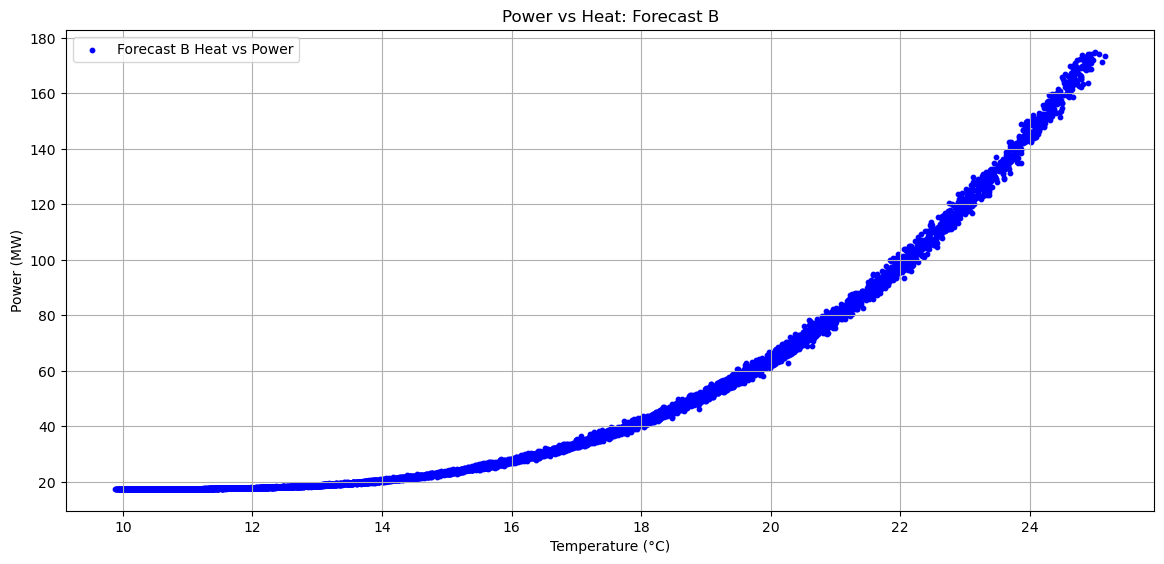

In [177]:
# Define shift date and power cap values
filter_start_date = datetime(2020, 2, 28, 16, 2, 0)
power_min = 17.5
power_max = 175.0

# This line definition I have picked by eye in order to easily remove the outliers. We remove all points below this line. This line has no unique properties I have just picked an abitrary line below the main data and above the outliers. 
def line_equation(x):
    return (20 / 3) * (x - 16) + 20

# Function to filter out unwanted data
def filter_data(timestamps, heat_values, power_values):
    filtered_heat_values = []
    filtered_power_values = []

    for ts, heat_value, power_value in zip(timestamps, heat_values, power_values):
        if ts > filter_start_date and power_min < power_value < power_max and power_value >= line_equation(heat_value):
            filtered_heat_values.append(heat_value)
            filtered_power_values.append(power_value)
    
    return filtered_heat_values, filtered_power_values

# Initialize dictionary to hold filtered data for Forecast B
filtered_data = {}

# Filter and save data for Forecast B
forecast_name = 'Forecast B'
if forecast_name in matching_data:
    heat_values, power_values = matching_data[forecast_name]
    timestamps = common_timestamps  # common_timestamps is defined in an ealier block of code

    # Apply filter and save data
    filtered_heat_values, filtered_power_values = filter_data(timestamps, heat_values, power_values)
    filtered_data[forecast_name] = (filtered_heat_values, filtered_power_values)

# Plot filtered data for Forecast B
fig, ax = plt.subplots(figsize=(12, 6))
heat_values, power_values = filtered_data[forecast_name]
ax.scatter(heat_values, power_values, color='b', marker='o', s=10, label=f'{forecast_name} Heat vs Power')
ax.set_ylabel('Power (MW)')
ax.set_xlabel('Temperature (°C)')
ax.set_title(f'Power vs Heat: {forecast_name}')
ax.grid(True)
ax.legend()

# Show the plot
plt.tight_layout(pad=2.0)
plt.show()

In [ ]:
'''
The graph now shows a very strong correlation between the 2 variables. We can now model this relationship and any temperatures outside the range of this graph we will assign the capped values. We will try a few methods now to best model this relationship.
'''

In [ ]:
# Access filtered data - we will use this data for the following models
filtered_heat_values, filtered_power_values = filtered_data['Forecast B']

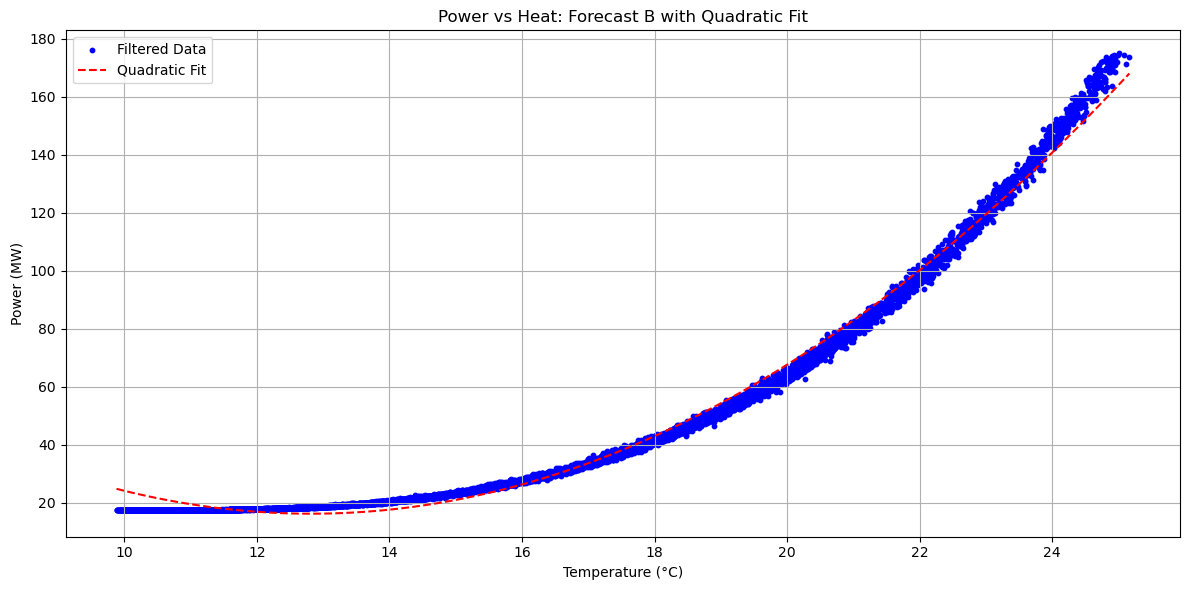

In [12]:
# Fit a quadratic polynomial
coefficients = np.polyfit(filtered_heat_values, filtered_power_values, 2)
polynomial = np.poly1d(coefficients)

# Generate values for plotting the quadratic
x_fit = np.linspace(min(filtered_heat_values), max(filtered_heat_values), 100)
y_fit = polynomial(x_fit)

# Plot the polynomial over the data
plt.figure(figsize=(12, 6))
plt.scatter(filtered_heat_values, filtered_power_values, color='b', marker='o', s=10, label='Filtered Data')
plt.plot(x_fit, y_fit, color='r', linestyle='--', label='Quadratic Fit')
plt.ylabel('Power (MW)')
plt.xlabel('Temperature (°C)')
plt.title('Power vs Heat: Forecast B with Quadratic Fit')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

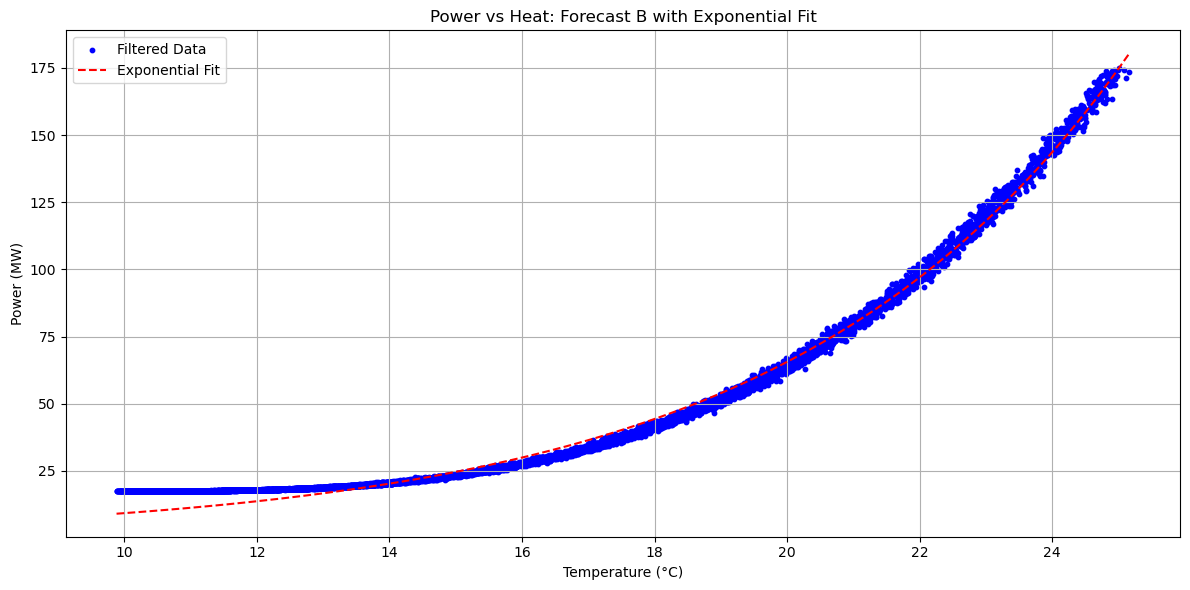

In [178]:
# Define exponential function for fitting
def exponential_func(x, a, b):
    return a * np.exp(b * x)

# Convert lists to numpy arrays
filtered_heat_values = np.array(filtered_heat_values)
filtered_power_values = np.array(filtered_power_values)
    
# Fit the exponential model to the filtered data
popt, _ = curve_fit(exponential_func, filtered_heat_values, filtered_power_values, p0=(1, 0.01))
a, b = popt

# Generate values for plotting the exponential
x_fit = np.linspace(min(filtered_heat_values), max(filtered_heat_values), 100)
y_fit = exponential_func(x_fit, *popt)

# Plot the exponential over the data
plt.figure(figsize=(12, 6))
plt.scatter(filtered_heat_values, filtered_power_values, color='b', marker='o', s=10, label='Filtered Data')
plt.plot(x_fit, y_fit, color='r', linestyle='--', label='Exponential Fit')
plt.ylabel('Power (MW)')
plt.xlabel('Temperature (°C)')
plt.title('Power vs Heat: Forecast B with Exponential Fit')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Piecewise Linear Fit 1 equation: y = 0.0099x + 2.7581
Piecewise Linear Fit 2 equation: y = 0.0685x + 2.0489
Piecewise Linear Fit 3 equation: y = 0.1487x + 0.9262
Piecewise Linear Fit 4 equation: y = 0.2034x + 0.0571
Piecewise Linear Fit 5 equation: y = 0.2189x + -0.2172
Piecewise Linear Fit 6 equation: y = 0.2135x + -0.1083
Piecewise Linear Fit 7 equation: y = 0.1978x + 0.2360
Piecewise Linear Fit 8 equation: y = 0.1782x + 0.7050


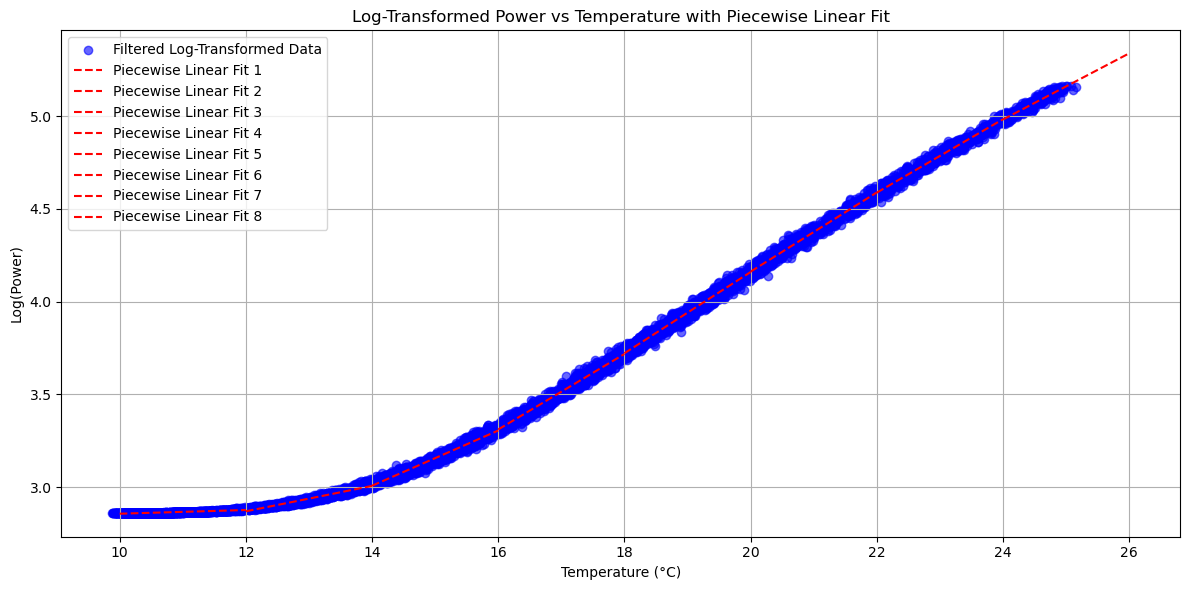

In [184]:
# Define temperature intervals for piecewise linear fit starting at 10
temp_intervals = np.arange(10, np.ceil(max(filtered_heat_values)) + 2, 2)
piecewise_lines = []

#Iterate through temperature intervals
for i in range(len(temp_intervals) - 1):
    temp_start = temp_intervals[i]
    temp_end = temp_intervals[i + 1]
    mask = (filtered_heat_values >= temp_start) & (filtered_heat_values < temp_end)
    segment_heat_values = filtered_heat_values[mask].reshape(-1, 1)
    segment_log_power_values = filtered_log_power_values[mask]

    
    # Fit a linear model to the log-transformed data
    model = LinearRegression()
    model.fit(segment_heat_values, segment_log_power_values)
    x_fit_segment = np.linspace(temp_start, temp_end, 100)
    y_fit_segment = model.predict(x_fit_segment.reshape(-1, 1))
    piecewise_lines.append((x_fit_segment, y_fit_segment, model.coef_[0], model.intercept_))

# Plot the peicewise linear model over the data
plt.figure(figsize=(12, 6))
plt.scatter(filtered_heat_values, filtered_log_power_values, color='blue', alpha=0.6, label='Filtered Log-Transformed Data')

for idx, (x_fit_segment, y_fit_segment, coef, intercept) in enumerate(piecewise_lines):
    plt.plot(x_fit_segment, y_fit_segment, linestyle='--', color='red', label=f'Piecewise Linear Fit {idx+1}')
    print(f'Piecewise Linear Fit {idx+1} equation: y = {coef:.4f}x + {intercept:.4f}')

plt.xlabel('Temperature (°C)')
plt.ylabel('Log(Power)')
plt.title('Log-Transformed Power vs Temperature with Piecewise Linear Fit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Polynomial equation: y = -28.333 + 13.824x + -1.388x^2 + 0.046x^3


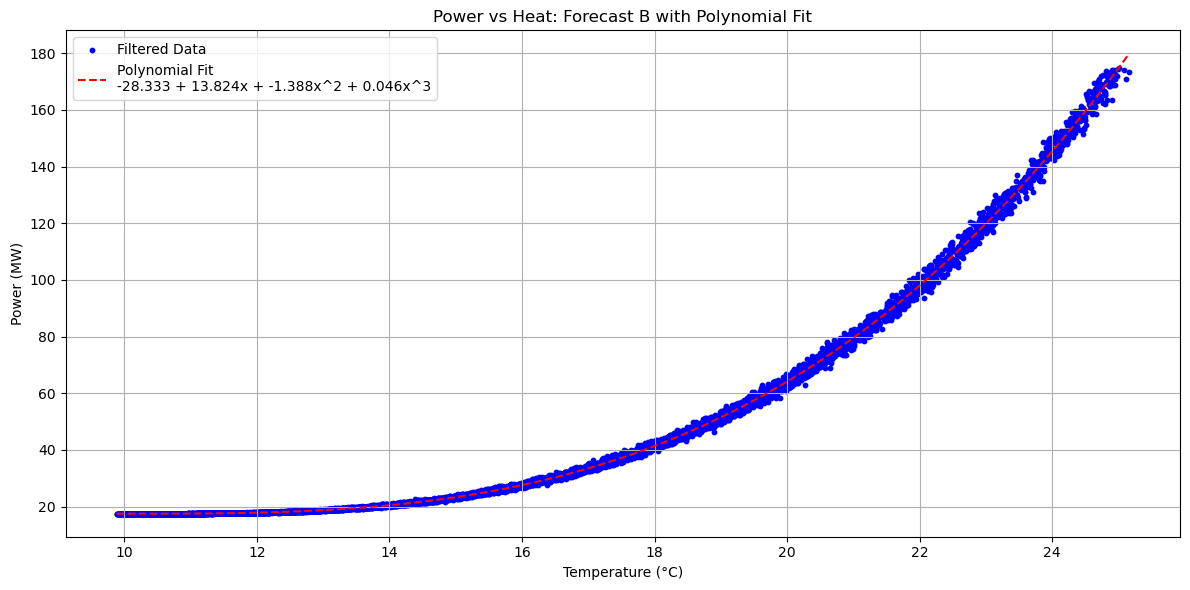

In [186]:
# Fit a polynomial of degree 3 (cubic) to the data
p = Polynomial.fit(filtered_heat_values, filtered_power_values, 3)
        
# Convert the coefficients to standard polynomial form
p_coeffs = p.convert().coef
        
# Generate the equation string
equation = f"{p_coeffs[0]:.3f} + {p_coeffs[1]:.3f}x + {p_coeffs[2]:.3f}x^2 + {p_coeffs[3]:.3f}x^3"
print(f"Polynomial equation: y = {equation}")

# Generate values for plotting the cubic
x_fit = np.linspace(min(filtered_heat_values), max(filtered_heat_values), 100)
y_fit = p(x_fit)

# Plot the cubic over the data
plt.figure(figsize=(12, 6))
plt.scatter(filtered_heat_values, filtered_power_values, color='b', marker='o', s=10, label='Filtered Data')
plt.plot(x_fit, y_fit, color='r', linestyle='--', label=f'Polynomial Fit\n{equation}')
plt.ylabel('Power (MW)')
plt.xlabel('Temperature (°C)')
plt.title('Power vs Heat: Forecast B with Polynomial Fit')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
    


In [ ]:
'''
Clearly the cubic model is by far the best fit so we will use this model to predict future values.
power = -28.333 + (13.824*temperature) + (-1.388 * ((temperature)**2)) + (0.046* ((temperature)**3))
'''

In [ ]:
'''
Summary of results
The output of the power plant is seasonal peaking in the middle of the year and reaching its lowest at the start/end of the year. It is capped above and below by
the values we calculated earlier. We see a change in the plants behavior just after the start of 2020 (the exact time and date is calculated earlier); the general
output of the plant increases alongside the caps. We also see a clear positive correlation (within a range) between temperature and power for all 3 forecasts.
Once we go above a certain temperature or below a certain temperature, the power output stops changing and this is most likely why we see caps in our original
graph. I can infer from the data that as temperature changes seasonally this effects the output of the power plant with higher temperatures producing more power,
however the analysis doesn't actually give any information about causation.
Firstly, it's important to note that as the behaviour of the plant changes just after the start of 2021 all previous data is not very helpful for making future
predictions. As a result we will only consider data after this date. We see a correlation between the power and 4 variables: time and the 3 forecasts. There is a
clear seasonal trend seen on the power time graph but the correlation is not that high. The correlation between power and heat is much stronger especially in
forecast B. As as result the data in Forecast B after the shift in behaviour seems to be the most useful for predicting the behaviour of the plant.
See the functions below for solutions to this question. I seem to be geeting slightly lower predicted power values compared to the historic data set. This could
just be variance from the model but really I would need more time to investigate this further.
I'm not sure what the structure of the live forecast data looks like; We could use a method such as linear interpolation to predict any missing values if this were
to be a problem but I haven't included code for this below.
Also, when working with the maintenance data we iterate through this 6 times and this could be reduced to 1 by first filtering the maintenace data. I ran out of time to
implement this.
'''

In [234]:
# Function to return a vector of forecast temperatures at the times we want to predict 

def get_temperatures_at_intervals(start_time_str):
    
    #Convert start_time_str to datetime
    start_time = datetime.strptime(start_time_str, '%Y-%m-%dT%H:%M:%S')

    #Access times and temperatures from forecast data
    timestamps, temperatures = forecast_data['Forecast B'] #Replace this with the live forecast data. I'm not sure what the structure of the live data looks like. We could use a method such as linear interpolation to predict any missing values if this is a problem. 

    
    # Intialise return vector
    temperature_intervals = []

    #Fill vector with forecast temperatures at the times we want to predict 
    for i in range(2, 8):  # 1 hour to 3.5 hours (6 intervals, 30 minutes each)
        target_time = start_time + timedelta(minutes=30 * i)
        temp = temperatures[timestamps.index(target_time)]
        temperature_intervals.append(temp)
   
    return temperature_intervals







# Function to predict power outputs using the cubic model and forecast temperatures

def Forecast(start_time_str):
    
    #Get temperatures at the times we want to predict using the previous function
    temperatures = get_temperatures_at_intervals(start_time_str)
    # Initialise output vector
    output = np.zeros(6)
    
    for i in range(6):
        
        # Access temperature value and substitute into the cubic model
        temperature = temperatures[i]
        power = -28.333 + (13.824*temperature) + (-1.388 * ((temperature)**2)) + (0.046* ((temperature)**3))

        #If the output is in the range of the model use that value, otherwise use the value of the caps
        if power > 175:
            output[i] = 175
        elif power < 17.5:
            output[i] = 17.5
        else:
            output[i] = power
        
    return output

# Call the function and print the results
start_time_str = '2021-02-24T14:00:00'
power_values = Forecast(start_time_str)
for i in range(6):
    print(power_values[i])

17.51867390981957
17.5
18.545482735889877
20.345110936212137
17.5
17.5


In [235]:
# Function to get the true power at the same time intervals from our data as a check

def get_power_at_intervals(data, start_time_str):
    
    #Convert start_time_str to datetime
    start_time = datetime.strptime(start_time_str, '%Y-%m-%dT%H:%M:%S')
    #Initialise output vector
    power_intervals = []
    
    for i in range(2, 8):  # 6 intervals (1 hour to 3.5 hours, 30-minute intervals)

        #Calculate target times and format them correctly to search power data
        target_time = start_time + timedelta(minutes=30 * i)
        target_time_str = target_time.strftime('%Y-%m-%dT%H:%M:%S')
        
        # Retrieve power output if available
        if target_time_str in data:
            power_intervals.append(data[target_time_str])
        else:
            power_intervals.append("Data Missing")
            
    return power_intervals


# Call the function and print the results
start_time_str = '2021-02-24T14:00:00'
power_values = get_power_at_intervals(data, start_time_str)
for i in range(6):
    print(power_values[i])

Data Missing
Data Missing
Data Missing
21.401384851080202
17.641122257259426
17.5


In [4]:
# Function to calculate power cap at a given time
def get_max_power_at_time(time_str, maintenance_data):
    
    # Convert time_str to datetime
    time = datetime.strptime(time_str, '%Y-%m-%dT%H:%M:%S')
    
    # Convert maintenance data times to datetime
    maintenance_data['start_time_csv'] = pd.to_datetime(maintenance_data['start_time_csv'], format='%Y-%m-%dT%H:%M:%S.%fZ')

    #Iterate through intervals of maintenance data to check if the time is within an interval
    for i in range(len(maintenance_data) - 1):
        row = maintenance_data.iloc[i]
        next_row = maintenance_data.iloc[i + 1]
        
        # Current maintenance window start time and power cap
        time_now = row['start_time_csv']
        max_output_now = row['max_output_mw']
        
        # Next maintenance window start time and power cap
        time_after = next_row['start_time_csv']
        max_output_after = next_row['max_output_mw']

    '''EDGE case?????'''
        # Flat power output for the first 5 minutes after time_now
    if time_now <= time <= time_now + timedelta(minutes=5):
        return float(max_output_now)
        
    # Flat power cap during the period between time_now + 5 minutes and time_after - 5 minutes
    elif time_now + timedelta(minutes=5) <= time <= time_after - timedelta(minutes=5):
        return float(max_output_now)
        
    # Ramp-down effect for the 5 minutes before time_after
    elif time_after - timedelta(minutes=5) <= time <= time_after + timedelta(minutes=5):
        # Perform ramp-down calculation
        return ((max_output_after - max_output_now) / 10) * \
                ((time - (time_after - timedelta(minutes=5))).total_seconds() / 60) + max_output_now

    # Calculates the final maintenance window as it is not iterated through above: 
    last_row = maintenance_data.iloc[-1]
    last_time = last_row['start_time_csv']
    last_output = last_row['max_output_mw']
    penultimate_row = maintenance_data.iloc[-2]
    penultimate_time = penultimate_row['start_time_csv']
    penultimate_output = penultimate_row['max_output_mw']

    #Final ramp
    if last_time <= time <= last_time + timedelta(minutes=5):
        return ((last_output - penultimate_output) / 10) * \
                   ((time - (last_time - timedelta(minutes=5))).total_seconds() / 60) + penultimate_output
    #Final flat cap
    elif time >= last_time + timedelta(minutes=5):
        return last_output


# Call the function and print the results
maintenance_data = pd.read_csv('maintenancedata.csv')
test_time_str = '2024-01-01T14:30:00'
power_cap = get_max_power_at_time(test_time_str, maintenance_data)
print(power_cap)

100.0


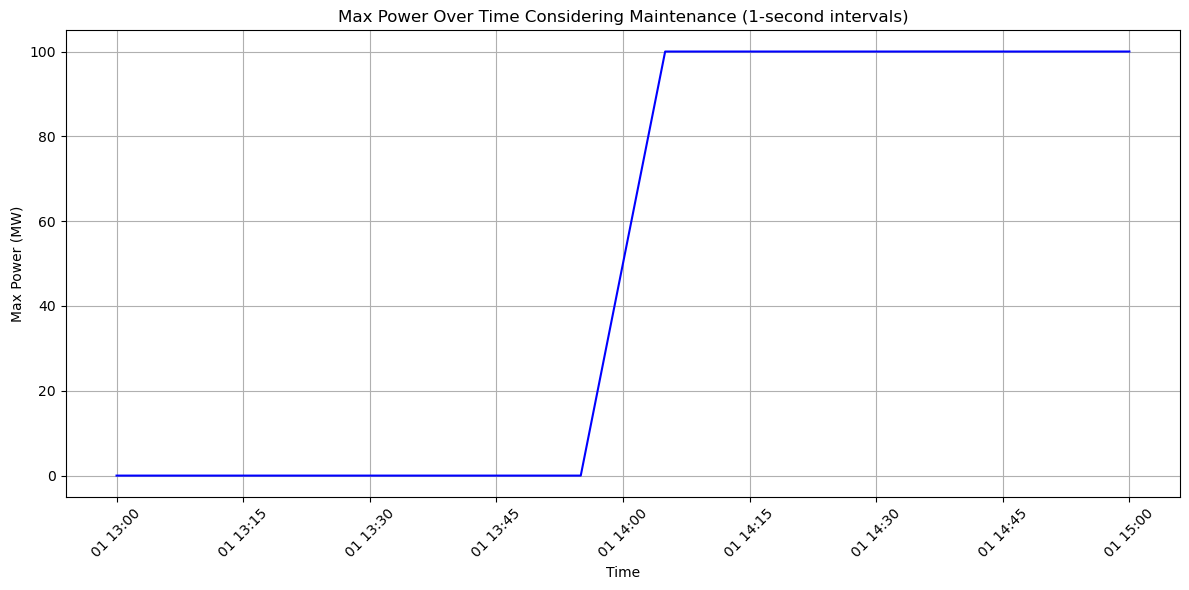

In [5]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Assuming maintenance_data is already loaded
# Convert start_time_csv to datetime objects if they are not already
maintenance_data['start_time_csv'] = pd.to_datetime(maintenance_data['start_time_csv'], format='%Y-%m-%dT%H:%M:%S.%fZ')

# Generate a range of times between the first and last timestamp in the maintenance data
start_time = maintenance_data['start_time_csv'].min()
end_time = maintenance_data['start_time_csv'].max() + timedelta(hours=1)

# Create a list of times to call the function for, now for every second
time_range = [start_time + timedelta(seconds=i) for i in range(int((end_time - start_time).total_seconds()) + 1)]

# Get max power for each time in the range
power_values = [get_max_power_at_time(time.strftime('%Y-%m-%dT%H:%M:%S'), maintenance_data) for time in time_range]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(time_range, power_values, marker='', linestyle='-', color='b')
plt.xlabel('Time')
plt.ylabel('Max Power (MW)')
plt.title('Max Power Over Time Considering Maintenance (1-second intervals)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [151]:
from datetime import datetime, timedelta
import pandas as pd

# Function to get max power every 30 minutes starting 1 hour after a given time
def get_power_in_intervals(maintenance_data, time_str):
    """
    Given maintenance data and a specific time, calculate max power starting 
    one hour after the input time and every 30 minutes for 6 intervals.
    
    Parameters:
    - maintenance_data: DataFrame with columns ['max_output_mw', 'start_time_csv']
    - time_str: input time in string format 'YYYY-MM-DDTHH:MM:SS'
    
    Returns:
    - List of max power values at 1-hour + 30-minute intervals for 6 time points.
    """
    # Convert input time string to datetime
    input_time = datetime.strptime(time_str, '%Y-%m-%dT%H:%M:%S')

    # List to store the max power results
    max_values = []

    # Loop for 6 intervals (every 30 minutes starting 1 hour after the input time)
    for i in range(6):
         # Calculate the current time, starting from 1 hour after the input time
        time_interval = input_time + timedelta(hours=1, minutes=30 * i)
        
        # Get max power at the current time interval
        power_at_time = get_max_power_at_time(time_interval.strftime('%Y-%m-%dT%H:%M:%S'), maintenance_data)
        
        # Append result to the list (just the power values, no time)
        # print (i,time_interval,power_at_time)
        max_values.append(power_at_time)

    return max_values

# Example usage:
# Replace with the actual path to your CSV file
maintenance_data = pd.read_csv('maintenancedata2.csv')

# Input time
input_time_str = '2021-09-12T10:00:00'

# Get max power for 6 intervals starting 1 hour after the input time
power_values = get_power_in_intervals(maintenance_data, input_time_str)

# Output the power values vector
print(power_values)


[52.5, 45.0, 62.5, 80.0, 40.0, 0.0]


In [215]:
def final_function(time_str, maintenance_data):
    output = []
    # Get power values at 30-minute intervals
    power_cap = get_power_in_intervals(maintenance_data, time_str)
    # Get forecasted power outputs
    power_values = Forecast(time_str)
    
    for i in range(6):
        # Check for NaN values using pd.isna()
        if pd.isna(power_cap[i]):
            capped_power = power_values[i]
        else:
            capped_power = min(power_cap[i], power_values[i])
        
        output.append(capped_power)
    
    return output

# Example usage:
# Replace with the actual path to your CSV file
maintenance_data = pd.read_csv('maintenancedata2.csv')
input_time_str = '2021-09-12T10:00:00'

# Get capped power values
solution = final_function(input_time_str, maintenance_data)

# Output the capped power values
print(solution)

[52.5, 37.99516623033651, 29.838815479076743, 26.46463141620316, 31.556312434127335, 0.0]
